## Lab | Making predictions with logistic regression

In this lab, you will be using the Sakila database of movie rentals.

In order to optimize our inventory, we would like to know which category of the firs 4 will be rented next month and we are asked to create a model to predict it.
Instructions

   1.  Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features.
   2. Read the data into a Pandas dataframe.
   3. Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.
   4. Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable.
   5. Create a logistic regression model to predict this variable from the cleaned data.
   6. Evaluate the results.


In [1]:
import pymysql
from sqlalchemy import create_engine

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [132]:
connection_string =  "mysql+pymysql://root:M28;sq07:l80_@localhost/sakila"
engine = create_engine(connection_string)
# data = pd.read_sql_query('SELECT * FROM loan', engine)
# data.head()

In [133]:
query = '''select *
from category c
join film_category fc
on c.category_id = fc.category_id
join film f
on fc.film_id = f.film_id
where c.category_id < 5;'''

data1 = pd.read_sql_query(query, engine)
data1.head()

,category_id,name,last_update,film_id,category_id,last_update,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update
0,1,Action,2006-02-15 04:46:27,19,1,2006-02-15 05:07:09,19,AMADEUS HOLY,A Emotional Display of a Pioneer And a Technic...,2006,1,None,6,0.99,113,20.99,PG,"Commentaries,Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42
1,1,Action,2006-02-15 04:46:27,21,1,2006-02-15 05:07:09,21,AMERICAN CIRCUS,A Insightful Drama of a Girl And a Astronaut w...,2006,1,None,3,4.99,129,17.99,R,"Commentaries,Behind the Scenes",2006-02-15 05:03:42
2,1,Action,2006-02-15 04:46:27,29,1,2006-02-15 05:07:09,29,ANTITRUST TOMATOES,A Fateful Yarn of a Womanizer And a Feminist w...,2006,1,None,5,2.99,168,11.99,NC-17,"Trailers,Commentaries,Deleted Scenes",2006-02-15 05:03:42
3,1,Action,2006-02-15 04:46:27,38,1,2006-02-15 05:07:09,38,ARK RIDGEMONT,A Beautiful Yarn of a Pioneer And a Monkey who...,2006,1,None,6,0.99,68,25.99,NC-17,"Trailers,Commentaries,Deleted Scenes,Behind th...",2006-02-15 05:03:42
4,1,Action,2006-02-15 04:46:27,56,1,2006-02-15 05:07:09,56,BAREFOOT MANCHURIAN,A Intrepid Story of a Cat And a Student who mu...,2006,1,None,6,2.99,129,15.99,G,"Trailers,Commentaries",2006-02-15 05:03:42


In [134]:
data = data1

In [135]:
data.columns

Index(['category_id', 'name', 'last_update', 'film_id', 'category_id',
       'last_update', 'film_id', 'title', 'description', 'release_year',
       'language_id', 'original_language_id', 'rental_duration', 'rental_rate',
       'length', 'replacement_cost', 'rating', 'special_features',
       'last_update'],
      dtype='object')

In [136]:
data.shape

(247, 19)

In [137]:
data_temp = data.drop(columns=['category_id', 'last_update', 'film_id', 'category_id', 'last_update','film_id', 'language_id', 'original_language_id', 'special_features', 'last_update'])

In [138]:
data_temp.head(2)

,name,title,description,release_year,rental_duration,rental_rate,length,replacement_cost,rating
0,Action,AMADEUS HOLY,A Emotional Display of a Pioneer And a Technic...,2006,6,0.99,113,20.99,PG
1,Action,AMERICAN CIRCUS,A Insightful Drama of a Girl And a Astronaut w...,2006,3,4.99,129,17.99,R


In [139]:
data = data_temp
data.shape

(247, 9)

In [140]:
# observatio of Y
data['name'].value_counts()

Animation    66
Action       64
Children     60
Classics     57
Name: name, dtype: int64

In [141]:
data.dtypes

name                 object
title                object
description          object
release_year          int64
rental_duration       int64
rental_rate         float64
length                int64
replacement_cost    float64
rating               object
dtype: object

In [142]:
data.isna().sum()/data.shape[0] # adding /data.shape[0] for get the % of nun vales 

name                0.0
title               0.0
description         0.0
release_year        0.0
rental_duration     0.0
rental_rate         0.0
length              0.0
replacement_cost    0.0
rating              0.0
dtype: float64

In [143]:
data = data[data['release_year'].isna() == False]

In [144]:
data.isna().sum()

name                0
title               0
description         0
release_year        0
rental_duration     0
rental_rate         0
length              0
replacement_cost    0
rating              0
dtype: int64

In [145]:
 data['release_year'].unique() # This are discret values and acts as duration of something. 
    # therefore we convert/consider it categorical
    
    
    

array([2006])

In [146]:
data["release_year"] = data["release_year"].astype("object") # This will be convert release_year from int64 to categorical

data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 247 entries, 0 to 246
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              247 non-null    object 
 1   title             247 non-null    object 
 2   description       247 non-null    object 
 3   release_year      247 non-null    object 
 4   rental_duration   247 non-null    int64  
 5   rental_rate       247 non-null    float64
 6   length            247 non-null    int64  
 7   replacement_cost  247 non-null    float64
 8   rating            247 non-null    object 
dtypes: float64(2), int64(2), object(5)
memory usage: 19.3+ KB


In [147]:
data.head()

,name,title,description,release_year,rental_duration,rental_rate,length,replacement_cost,rating
0,Action,AMADEUS HOLY,A Emotional Display of a Pioneer And a Technic...,2006,6,0.99,113,20.99,PG
1,Action,AMERICAN CIRCUS,A Insightful Drama of a Girl And a Astronaut w...,2006,3,4.99,129,17.99,R
2,Action,ANTITRUST TOMATOES,A Fateful Yarn of a Womanizer And a Feminist w...,2006,5,2.99,168,11.99,NC-17
3,Action,ARK RIDGEMONT,A Beautiful Yarn of a Pioneer And a Monkey who...,2006,6,0.99,68,25.99,NC-17
4,Action,BAREFOOT MANCHURIAN,A Intrepid Story of a Cat And a Student who mu...,2006,6,2.99,129,15.99,G


In [148]:
data = data.drop(columns=["description"])
data.head()

,name,title,release_year,rental_duration,rental_rate,length,replacement_cost,rating
0,Action,AMADEUS HOLY,2006,6,0.99,113,20.99,PG
1,Action,AMERICAN CIRCUS,2006,3,4.99,129,17.99,R
2,Action,ANTITRUST TOMATOES,2006,5,2.99,168,11.99,NC-17
3,Action,ARK RIDGEMONT,2006,6,0.99,68,25.99,NC-17
4,Action,BAREFOOT MANCHURIAN,2006,6,2.99,129,15.99,G


In [149]:
data['rental_duration'].value_counts() # distribution of values in the columns .
# these values are discrete periods. Should be convert ot categorical

3    54
6    52
7    49
4    46
5    46
Name: rental_duration, dtype: int64

In [150]:
data["rental_duration"] = data["rental_duration"].astype(object)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247 entries, 0 to 246
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              247 non-null    object 
 1   title             247 non-null    object 
 2   release_year      247 non-null    object 
 3   rental_duration   247 non-null    object 
 4   rental_rate       247 non-null    float64
 5   length            247 non-null    int64  
 6   replacement_cost  247 non-null    float64
 7   rating            247 non-null    object 
dtypes: float64(2), int64(1), object(5)
memory usage: 17.4+ KB


In [151]:
data["rating"].value_counts()

PG-13    57
G        52
NC-17    48
PG       45
R        45
Name: rating, dtype: int64

In [152]:
data["title"].value_counts()

ENTRAPMENT SATISFACTION    1
DARN FORRESTER             1
TWISTED PIRATES            1
TADPOLE PARK               1
STORM HAPPINESS            1
                          ..
OCTOBER SUBMARINE          1
MAGNOLIA FORRESTER         1
STRANGER STRANGERS         1
SANTA PARIS                1
LABYRINTH LEAGUE           1
Name: title, Length: 247, dtype: int64

In [153]:
data.isna().sum()

name                0
title               0
release_year        0
rental_duration     0
rental_rate         0
length              0
replacement_cost    0
rating              0
dtype: int64

In [154]:
data.describe() # basic statistics of numericals

,rental_rate,length,replacement_cost
count,247.000000,247.000000,247.000000
mean,2.771377,111.024291,20.516316
std,1.603089,40.311281,6.239651
min,0.990000,46.000000,9.990000
25%,0.990000,78.500000,14.990000
50%,2.990000,108.000000,20.990000
75%,4.990000,143.000000,25.990000
max,4.990000,185.000000,29.990000


In [155]:
data.shape

(247, 8)

In [156]:
data.head(10)

,name,title,release_year,rental_duration,rental_rate,length,replacement_cost,rating
0,Action,AMADEUS HOLY,2006,6,0.99,113,20.99,PG
1,Action,AMERICAN CIRCUS,2006,3,4.99,129,17.99,R
2,Action,ANTITRUST TOMATOES,2006,5,2.99,168,11.99,NC-17
3,Action,ARK RIDGEMONT,2006,6,0.99,68,25.99,NC-17
4,Action,BAREFOOT MANCHURIAN,2006,6,2.99,129,15.99,G
5,Action,BERETS AGENT,2006,5,2.99,77,24.99,PG-13
6,Action,BRIDE INTRIGUE,2006,7,0.99,56,24.99,G
7,Action,BULL SHAWSHANK,2006,6,0.99,125,21.99,NC-17
8,Action,CADDYSHACK JEDI,2006,3,0.99,52,17.99,NC-17
9,Action,CAMPUS REMEMBER,2006,5,2.99,167,27.99,R


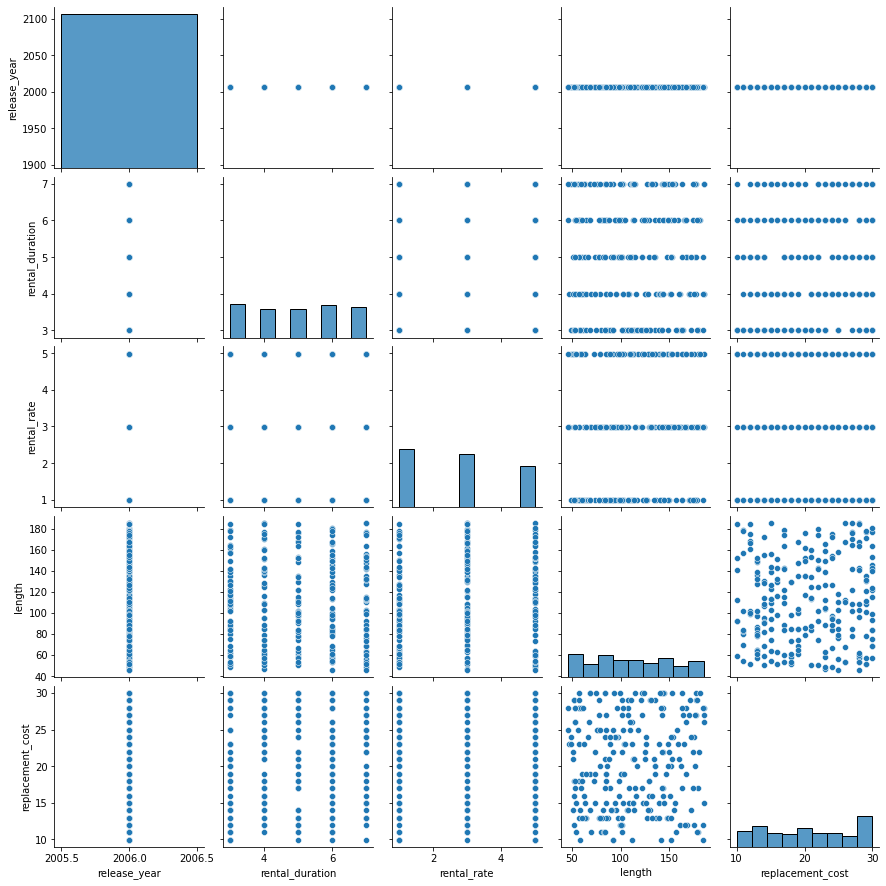

In [51]:
sns.pairplot(data)

In [157]:
nulls_df = pd.DataFrame(round(data.isna().sum()/len(data),4)*100)
nulls_df = nulls_df.reset_index()
nulls_df

,index,0
0,name,0.0
1,title,0.0
2,release_year,0.0
3,rental_duration,0.0
4,rental_rate,0.0
5,length,0.0
6,replacement_cost,0.0
7,rating,0.0


In [158]:
data["rental_rate"].value_counts()

0.99    94
2.99    86
4.99    67
Name: rental_rate, dtype: int64

In [159]:
# rental_rate should be converted to categorical. It has three discrete values
data["rental_rate"] = data["rental_rate"].astype(object)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247 entries, 0 to 246
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              247 non-null    object 
 1   title             247 non-null    object 
 2   release_year      247 non-null    object 
 3   rental_duration   247 non-null    object 
 4   rental_rate       247 non-null    object 
 5   length            247 non-null    int64  
 6   replacement_cost  247 non-null    float64
 7   rating            247 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 17.4+ KB


#### Checking Correlation among the numericals

In [160]:
numericals = data.select_dtypes(include=np.number)

In [161]:
numericals.corr

<bound method DataFrame.corr of      length  replacement_cost
0       113             20.99
1       129             17.99
2       168             11.99
3        68             25.99
4       129             15.99
..      ...               ...
242     144             14.99
243     132             12.99
244      78             28.99
245      85             18.99
246      52             11.99

[247 rows x 2 columns]>

In [162]:
import matplotlib.pyplot as plt
%matplotlib inline

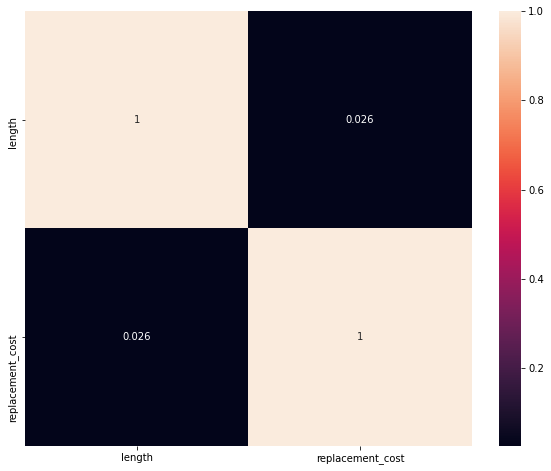

In [126]:
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

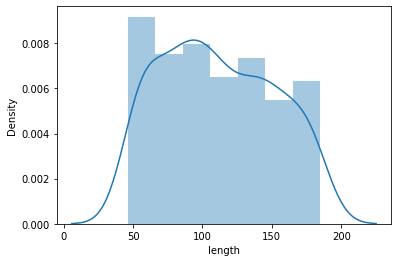

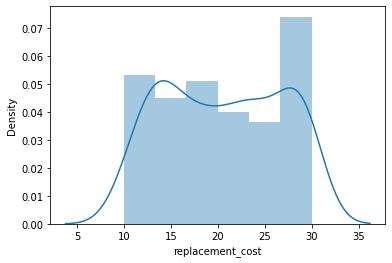

In [127]:
for i in range(numericals.shape[1]):
    sns.distplot(numericals[numericals.columns[i]])
    plt.show()

In [164]:
from sklearn.preprocessing import Normalizer
# from sklearn.preprocessing import StandardScaler
import numpy as np
X = numericals #data.select_dtypes(include = np.number)

# Normalizing data
transformer = Normalizer().fit(X)
x_normalized = transformer.transform(X)
x = pd.DataFrame(x_normalized)

In [165]:
x.head()

,0,1
0,0.983182,0.182628
1,0.990415,0.138121
2,0.997463,0.071188
3,0.934098,0.357018
4,0.992405,0.123012


In [166]:
data["name"].value_counts()

Animation    66
Action       64
Children     60
Classics     57
Name: name, dtype: int64

#### Dealing with categorical encoding with dummies

In [167]:
cat = data.select_dtypes(include = np.object)
cat = cat.drop(["name"], axis=1)

cat.head(10)

,title,release_year,rental_duration,rental_rate,rating
0,AMADEUS HOLY,2006,6,0.99,PG
1,AMERICAN CIRCUS,2006,3,4.99,R
2,ANTITRUST TOMATOES,2006,5,2.99,NC-17
3,ARK RIDGEMONT,2006,6,0.99,NC-17
4,BAREFOOT MANCHURIAN,2006,6,2.99,G
5,BERETS AGENT,2006,5,2.99,PG-13
6,BRIDE INTRIGUE,2006,7,0.99,G
7,BULL SHAWSHANK,2006,6,0.99,NC-17
8,CADDYSHACK JEDI,2006,3,0.99,NC-17
9,CAMPUS REMEMBER,2006,5,2.99,R


In [168]:

categorical = pd.get_dummies(cat)
categorical.head(10)

,title_ALICE FANTASIA,title_ALTER VICTORY,title_AMADEUS HOLY,title_AMERICAN CIRCUS,title_ANACONDA CONFESSIONS,title_ANTITRUST TOMATOES,title_ARGONAUTS TOWN,title_ARIZONA BANG,title_ARK RIDGEMONT,title_BACKLASH UNDEFEATED,title_BAREFOOT MANCHURIAN,title_BEAR GRACELAND,title_BEAST HUNCHBACK,title_BENEATH RUSH,title_BERETS AGENT,title_BETRAYED REAR,title_BIKINI BORROWERS,title_BLACKOUT PRIVATE,title_BORROWERS BEDAZZLED,title_BOUND CHEAPER,title_BRIDE INTRIGUE,title_BULL SHAWSHANK,title_CABIN FLASH,title_CADDYSHACK JEDI,title_CAMPUS REMEMBER,title_CANDIDATE PERDITION,title_CANYON STOCK,title_CAROL TEXAS,title_CASPER DRAGONFLY,title_CASUALTIES ENCINO,title_CELEBRITY HORN,title_CENTER DINOSAUR,title_CHAMPION FLATLINERS,title_CHRISTMAS MOONSHINE,title_CIRCUS YOUTH,title_CLASH FREDDY,title_CLOCKWORK PARADISE,title_CLUB GRAFFITI,title_CLUELESS BUCKET,title_COLOR PHILADELPHIA,title_COMANCHEROS ENEMY,title_CONSPIRACY SPIRIT,title_CORE SUIT,title_CREEPERS KANE,title_CROOKED FROGMEN,title_CROSSROADS CASUALTIES,title_CROW GREASE,title_CRUELTY UNFORGIVEN,title_DANCES NONE,title_DARES PLUTO,title_DARKO DORADO,title_DARN FORRESTER,title_DAUGHTER MADIGAN,title_DESIRE ALIEN,title_DETECTIVE VISION,title_DEVIL DESIRE,title_DOCTOR GRAIL,title_DOGMA FAMILY,title_DONNIE ALLEY,title_DOORS PRESIDENT,title_DOUBLE WRATH,title_DRACULA CRYSTAL,title_DRAGON SQUAD,title_DREAM PICKUP,title_DRIFTER COMMANDMENTS,title_DUCK RACER,title_DYNAMITE TARZAN,title_EARLY HOME,title_EASY GLADIATOR,title_EMPIRE MALKOVICH,title_ENTRAPMENT SATISFACTION,title_EXCITEMENT EVE,title_EXTRAORDINARY CONQUERER,title_FALCON VOLUME,title_FANTASY TROOPERS,title_FARGO GANDHI,title_FIGHT JAWBREAKER,title_FIREHOUSE VIETNAM,title_FLOATS GARDEN,title_FLYING HOOK,title_FOOL MOCKINGBIRD,title_FOREVER CANDIDATE,title_FORREST SONS,title_FORRESTER COMANCHEROS,title_FROST HEAD,title_FULL FLATLINERS,title_FURY MURDER,title_GALAXY SWEETHEARTS,title_GANGS PRIDE,title_GHOST GROUNDHOG,title_GHOSTBUSTERS ELF,title_GIANT TROOPERS,title_GILBERT PELICAN,title_GILMORE BOILED,title_GLASS DYING,title_GORGEOUS BINGO,title_GOSFORD DONNIE,title_GRADUATE LORD,title_GRAIL FRANKENSTEIN,title_HALL CASSIDY,title_HANDICAP BOONDOCK,title_HARPER DYING,title_HEARTBREAKERS BRIGHT,title_HILLS NEIGHBORS,title_HOLLYWOOD ANONYMOUS,title_HOLOCAUST HIGHBALL,title_HOLY TADPOLE,title_HOOK CHARIOTS,title_HOPE TOOTSIE,title_HORN WORKING,title_HYDE DOCTOR,title_IDOLS SNATCHERS,title_INCH JET,title_INSECTS STONE,title_INTENTIONS EMPIRE,title_INVASION CYCLONE,title_IRON MOON,title_ISHTAR ROCKETEER,title_ISLAND EXORCIST,title_JEEPERS WEDDING,title_JEOPARDY ENCINO,title_JERK PAYCHECK,title_JERSEY SASSY,title_JINGLE SAGEBRUSH,title_JUGGLER HARDLY,title_JUMPING WRATH,title_KISSING DOLLS,title_LABYRINTH LEAGUE,title_LANGUAGE COWBOY,title_LAWLESS VISION,title_LAWRENCE LOVE,title_LEAGUE HELLFIGHTERS,title_LEGALLY SECRETARY,title_LIGHTS DEER,title_LOATHING LEGALLY,title_LORD ARIZONA,title_LOVELY JINGLE,title_LOVER TRUMAN,title_LUKE MUMMY,title_LUST LOCK,title_MAGIC MALLRATS,title_MAGNIFICENT CHITTY,title_MAGNOLIA FORRESTER,title_MAKER GABLES,title_MALKOVICH PET,title_MASSAGE IMAGE,title_MENAGERIE RUSHMORE,title_MICROCOSMOS PARADISE,title_MIDNIGHT WESTWARD,title_MILLION ACE,title_MINDS TRUMAN,title_MIRACLE VIRTUAL,title_MISSION ZOOLANDER,title_MOCKINGBIRD HOLLYWOOD,title_MODEL FISH,title_MONTEZUMA COMMAND,title_MURDER ANTITRUST,title_MUSKETEERS WAIT,title_NASH CHOCOLAT,title_NOON PAPI,title_OCTOBER SUBMARINE,title_OSCAR GOLD,title_OZ LIAISONS,title_PACKER MADIGAN,title_PAJAMA JAWBREAKER,title_PARK CITIZEN,title_PATIENT SISTER,title_PATRIOT ROMAN,title_POLISH BROOKLYN,title_POND SEATTLE,title_POTLUCK MIXED,title_POTTER CONNECTICUT,title_PREJUDICE OLEANDER,title_PRIDE ALAMO,title_PRIMARY GLASS,title_PUNK DIVORCE,title_QUEST MUSSOLINI,title_REAR TRADING,title_REQUIEM TYCOON,title_RIGHT CRANES,title_RINGS HEARTBREAKERS,title_ROBBERS JOON,title_ROOM ROMAN,title_ROOTS REMEMBER,title_RUGRATS SHAKESPEARE,title_SABRINA MIDNIGHT,title_SANTA PARIS,titl

In [169]:
y = data['name']

In [170]:
y.value_counts()

Animation    66
Action       64
Children     60
Classics     57
Name: name, dtype: int64

### Apply LogisticRegression Model

In [171]:

X = np.concatenate((x, categorical), axis=1)

In [181]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [182]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train, y_train)

In [183]:
classification.score(X_test, y_test)
# 22% with 30% test
#18% with 40% test

0.22666666666666666

In [175]:
predictions = classification.predict(X_test)
classification.score(X_test, y_test)

0.18181818181818182

In [176]:
pd.Series(predictions).value_counts()

Action       40
Children     31
Animation    23
Classics      5
dtype: int64

In [177]:
y_test.value_counts()

Classics     28
Animation    25
Action       24
Children     22
Name: name, dtype: int64

In [178]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[ 9,  5, 10,  0],
       [ 8,  5, 10,  2],
       [10,  5,  4,  3],
       [13,  8,  7,  0]])

In [49]:
# from sklearn import metrics
# import matplotlib.pyplot as plt

# y_pred_proba = classification.predict_proba(X_test)[::,1]
# fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
# auc = metrics.roc_auc_score(y_test, y_pred_proba)
# plt.plot(fpr,tpr)

In [179]:
classification.predict_proba(X_test)

array([[0.26461625, 0.16990163, 0.37702582, 0.1884563 ],
       [0.27310454, 0.36375544, 0.23513149, 0.12800852],
       [0.3602099 , 0.13936538, 0.34945271, 0.15097201],
       [0.21753763, 0.26637571, 0.37111869, 0.14496797],
       [0.22612094, 0.26724496, 0.36469201, 0.14194209],
       [0.490904  , 0.17045022, 0.09537945, 0.24326634],
       [0.37635045, 0.31675022, 0.14808189, 0.15881744],
       [0.25952618, 0.21708131, 0.24201221, 0.2813803 ],
       [0.22707546, 0.25455097, 0.35966131, 0.15871226],
       [0.15207884, 0.34388463, 0.25135887, 0.25267765],
       [0.1802533 , 0.47413159, 0.20562146, 0.13999365],
       [0.360705  , 0.14127088, 0.2540702 , 0.24395391],
       [0.40873014, 0.08832128, 0.2300422 , 0.27290637],
       [0.35040724, 0.3346003 , 0.15245715, 0.16253531],
       [0.42127243, 0.23130528, 0.20685522, 0.14056707],
       [0.15367338, 0.34179893, 0.3474473 , 0.15708039],
       [0.34455608, 0.2440022 , 0.23343821, 0.17800351],
       [0.27126545, 0.17021036,

In [107]:
classification.predict_proba(X_test)[::,0]

array([0.26321833, 0.23397982, 0.32600723, 0.23019215, 0.23888234,
       0.42514877, 0.28065442, 0.26002163, 0.21236198, 0.1760147 ,
       0.16152473, 0.3707966 , 0.35436533, 0.31956794, 0.34178012,
       0.15475928, 0.30961962, 0.2694849 , 0.35369518, 0.16877789,
       0.23791789, 0.16404831, 0.19318757, 0.44326923, 0.14697187,
       0.39109213, 0.18530439, 0.17373773, 0.16445812, 0.18393243,
       0.20745058, 0.15465993, 0.2541914 , 0.40775418, 0.41472659,
       0.42686393, 0.46570451, 0.22755758, 0.19106401, 0.22998929,
       0.15749392, 0.26581474, 0.33668605, 0.2907054 , 0.40960156,
       0.22243063, 0.21846211, 0.22257042, 0.35806321, 0.43186191,
       0.15654531, 0.28999324, 0.27906194, 0.15900369, 0.17967655,
       0.43993247, 0.3508737 , 0.21993209, 0.24549189, 0.31539314,
       0.37683681, 0.22584987, 0.31436392, 0.37862383, 0.11618264,
       0.19990715, 0.31933864, 0.27940342, 0.20797585, 0.26863927,
       0.16365036, 0.18103606, 0.28470166, 0.12452739, 0.37201